# Top 50 vs SPX Implied Volatility Spread Analysis
## 10-Year Implied Volatility Arbitrage Opportunities: Concentrated vs Diversified Options
### Analyze the systematic pricing differences between Top 50 basket implied volatility and SPX Index implied volatility to identify potential volatility arbitrage strategies.

#### Setup and Data Preparation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("📊 IMPLIED VOLATILITY SPREAD ANALYSIS: TOP 50 vs SPX")
print("=" * 70)
print("Volatility arbitrage opportunities in concentrated vs diversified options")

📊 IMPLIED VOLATILITY SPREAD ANALYSIS: TOP 50 vs SPX
Volatility arbitrage opportunities in concentrated vs diversified options


In [11]:
# Load the 10-year volatility data
vol_data_path = '../data/historical_volatility/ten_year_volatility_latest.csv'
vol_df = pd.read_csv(vol_data_path)
vol_df['date'] = pd.to_datetime(vol_df['date'])

# Load SPX weights for Top 50 components
weights_path = '../data/processed/spx_weights/spx_weights_latest.csv'

try:
    weights_df = pd.read_csv(weights_path)
    top_50_weights = weights_df.head(50).copy()
    
    # Normalize weights to sum to 100%
    total_weight = top_50_weights['market_cap_weight_pct'].sum()
    top_50_weights['normalized_weight'] = (top_50_weights['market_cap_weight_pct'] / total_weight) * 100
    
    print(f"✅ Using market cap weights for Top 50 implied vol basket")
    print(f"   Top 50 represents {total_weight:.1f}% of SPX market cap")
    
except FileNotFoundError:
    print("⚠️ Using equal weights for Top 50 implied vol basket")
    component_tickers = vol_df[vol_df['ticker'] != 'SPX Index']['ticker'].unique()[:50]
    top_50_weights = pd.DataFrame({
        'ticker': component_tickers,
        'normalized_weight': [100/50] * 50
    })

print(f"\nTop 50 Implied Vol Basket composition:")
for i, row in top_50_weights.head(10).iterrows():
    ticker_clean = row['ticker'].replace(' US Equity', '')
    print(f"   {i+1:2d}. {ticker_clean:8s} {row['normalized_weight']:5.2f}%")

✅ Using market cap weights for Top 50 implied vol basket
   Top 50 represents 75.1% of SPX market cap

Top 50 Implied Vol Basket composition:
    1. NVDA     18.45%
    2. AAPL     13.83%
    3. AMZN     10.53%
    4. META      7.76%
    5. AVGO      5.84%
    6. V         3.03%
    7. NFLX      2.25%
    8. MA        2.20%
    9. XOM       2.04%
   10. PG        1.59%


#### Calculate Top 50 Basket Implied Volatility

In [3]:
def calculate_top50_implied_volatility(vol_data, weights_df):
    """
    Calculate market cap weighted Top 50 basket implied volatility across all tenors
    """
    print(f"\n📈 CALCULATING TOP 50 BASKET IMPLIED VOLATILITY")
    print("=" * 60)
    
    # Get implied volatility data
    implied_data = vol_data[vol_data['data_type'] == 'implied'].copy()
    
    # Implied vol fields to analyze
    implied_vol_fields = {
        'implied_vol_1m_atm': '1M ATM',
        'implied_vol_3m_atm': '3M ATM', 
        'implied_vol_6m_atm': '6M ATM',
        'implied_vol_12m_atm': '12M ATM'
    }
    
    # Create weights lookup
    weights_lookup = weights_df.set_index('ticker')['normalized_weight'].to_dict()
    
    # Find components with implied vol data
    valid_tickers = []
    for ticker in weights_df['ticker']:
        ticker_data = implied_data[implied_data['ticker'] == ticker]
        if len(ticker_data) > 0:
            # Check if any implied vol fields have data
            has_implied_data = any(ticker_data[field].notna().sum() > 50 for field in implied_vol_fields.keys())
            if has_implied_data:
                valid_tickers.append(ticker)
    
    print(f"Valid components with implied vol data: {len(valid_tickers)}/{len(weights_df)}")
    
    # Calculate basket implied volatility for each tenor
    all_dates = sorted(implied_data['date'].unique())
    basket_implied_results = []
    
    for date in all_dates:
        date_data = implied_data[implied_data['date'] == date]
        basket_row = {'date': date}
        
        # Calculate weighted implied vol for each tenor
        for field, field_name in implied_vol_fields.items():
            date_vol_data = {}
            total_weight_available = 0
            
            for ticker in valid_tickers:
                ticker_row = date_data[date_data['ticker'] == ticker]
                if len(ticker_row) > 0 and ticker_row[field].notna().iloc[0]:
                    vol_value = ticker_row[field].iloc[0]
                    weight = weights_lookup[ticker]
                    date_vol_data[ticker] = {'vol': vol_value, 'weight': weight}
                    total_weight_available += weight
            
            # Calculate weighted average if sufficient coverage
            if total_weight_available > 50:  # At least 50% weight coverage
                weighted_vol = 0
                for ticker, data in date_vol_data.items():
                    normalized_weight = (data['weight'] / total_weight_available)
                    weighted_vol += data['vol'] * normalized_weight
                
                basket_row[f'top50_{field}'] = weighted_vol
                basket_row[f'top50_{field}_coverage'] = total_weight_available
                basket_row[f'top50_{field}_components'] = len(date_vol_data)
            else:
                basket_row[f'top50_{field}'] = np.nan
                basket_row[f'top50_{field}_coverage'] = total_weight_available
                basket_row[f'top50_{field}_components'] = len(date_vol_data)
        
        basket_implied_results.append(basket_row)
    
    basket_implied_df = pd.DataFrame(basket_implied_results)
    
    # Print summary statistics
    for field, field_name in implied_vol_fields.items():
        top50_field = f'top50_{field}'
        valid_obs = basket_implied_df[top50_field].notna().sum()
        avg_coverage = basket_implied_df[f'{top50_field}_coverage'].mean()
        
        print(f"   {field_name:8s}: {valid_obs:4,} observations, {avg_coverage:.1f}% avg coverage")
    
    return basket_implied_df

# Calculate Top 50 basket implied volatility
top50_implied_basket = calculate_top50_implied_volatility(vol_df, top_50_weights)


📈 CALCULATING TOP 50 BASKET IMPLIED VOLATILITY
Valid components with implied vol data: 50/50
   1M ATM  :    0 observations, 0.0% avg coverage
   3M ATM  : 2,515 observations, 99.5% avg coverage
   6M ATM  : 2,515 observations, 99.5% avg coverage
   12M ATM : 2,515 observations, 99.5% avg coverage


#### Get SPX Index Implied Volatility

In [4]:
# Extract SPX Index implied volatility
spx_implied = vol_df[
    (vol_df['ticker'] == 'SPX Index') & 
    (vol_df['data_type'] == 'implied')
].copy()

print(f"\n📊 SPX INDEX IMPLIED VOLATILITY DATA")
print(f"   SPX implied vol observations: {len(spx_implied):,}")

# Check availability by tenor
implied_vol_fields = ['implied_vol_1m_atm', 'implied_vol_3m_atm', 'implied_vol_6m_atm', 'implied_vol_12m_atm']
for field in implied_vol_fields:
    if field in spx_implied.columns:
        valid_count = spx_implied[field].notna().sum()
        print(f"   {field}: {valid_count:,} data points")

print(f"   Date range: {spx_implied['date'].min().strftime('%Y-%m-%d')} to {spx_implied['date'].max().strftime('%Y-%m-%d')}")


📊 SPX INDEX IMPLIED VOLATILITY DATA
   SPX implied vol observations: 2,515
   implied_vol_1m_atm: 0 data points
   implied_vol_3m_atm: 2,515 data points
   implied_vol_6m_atm: 2,515 data points
   implied_vol_12m_atm: 2,515 data points
   Date range: 2015-07-20 to 2025-07-18


#### Create Implied Volatility Spread Dataset

In [5]:
# Merge Top 50 basket and SPX implied volatility data
print(f"\n🔄 CREATING IMPLIED VOLATILITY SPREAD DATASET")
print("=" * 60)

# Select relevant columns from SPX data
spx_iv_clean = spx_implied[['date'] + implied_vol_fields].copy()

# Merge with Top 50 basket data
spread_dataset = pd.merge(top50_implied_basket, spx_iv_clean, on='date', how='inner')

print(f"Merged dataset: {len(spread_dataset):,} observations")
print(f"Date range: {spread_dataset['date'].min().strftime('%Y-%m-%d')} to {spread_dataset['date'].max().strftime('%Y-%m-%d')}")

# Calculate spreads for each tenor
spread_calculations = {}

for field in implied_vol_fields:
    top50_field = f'top50_{field}'
    spx_field = field
    spread_field = f'spread_{field}'
    
    if top50_field in spread_dataset.columns and spx_field in spread_dataset.columns:
        # Calculate spread: Top 50 - SPX
        spread_dataset[spread_field] = spread_dataset[top50_field] - spread_dataset[spx_field]
        
        # Calculate summary stats
        valid_spreads = spread_dataset[spread_field].notna()
        spread_data = spread_dataset[valid_spreads]
        
        if len(spread_data) > 0:
            spread_calculations[field] = {
                'observations': len(spread_data),
                'mean_spread': spread_data[spread_field].mean(),
                'median_spread': spread_data[spread_field].median(),
                'std_spread': spread_data[spread_field].std(),
                'min_spread': spread_data[spread_field].min(),
                'max_spread': spread_data[spread_field].max(),
                'top50_higher_pct': (spread_data[spread_field] > 0).mean() * 100
            }
            
            print(f"\n{field} spread summary:")
            print(f"   Observations: {spread_calculations[field]['observations']:,}")
            print(f"   Mean spread: {spread_calculations[field]['mean_spread']:+.3f}%")
            print(f"   Std deviation: {spread_calculations[field]['std_spread']:.3f}%")
            print(f"   Top 50 higher: {spread_calculations[field]['top50_higher_pct']:.1f}% of time")

print(f"\nSpread dataset ready with {len(spread_dataset):,} observations")


🔄 CREATING IMPLIED VOLATILITY SPREAD DATASET
Merged dataset: 2,515 observations
Date range: 2015-07-20 to 2025-07-18

implied_vol_3m_atm spread summary:
   Observations: 2,515
   Mean spread: +15.266%
   Std deviation: 2.074%
   Top 50 higher: 100.0% of time

implied_vol_6m_atm spread summary:
   Observations: 2,515
   Mean spread: +14.281%
   Std deviation: 1.811%
   Top 50 higher: 100.0% of time

implied_vol_12m_atm spread summary:
   Observations: 2,515
   Mean spread: +13.552%
   Std deviation: 1.487%
   Top 50 higher: 100.0% of time

Spread dataset ready with 2,515 observations


#### Visualize 10-Year Implied Volatility Spreads

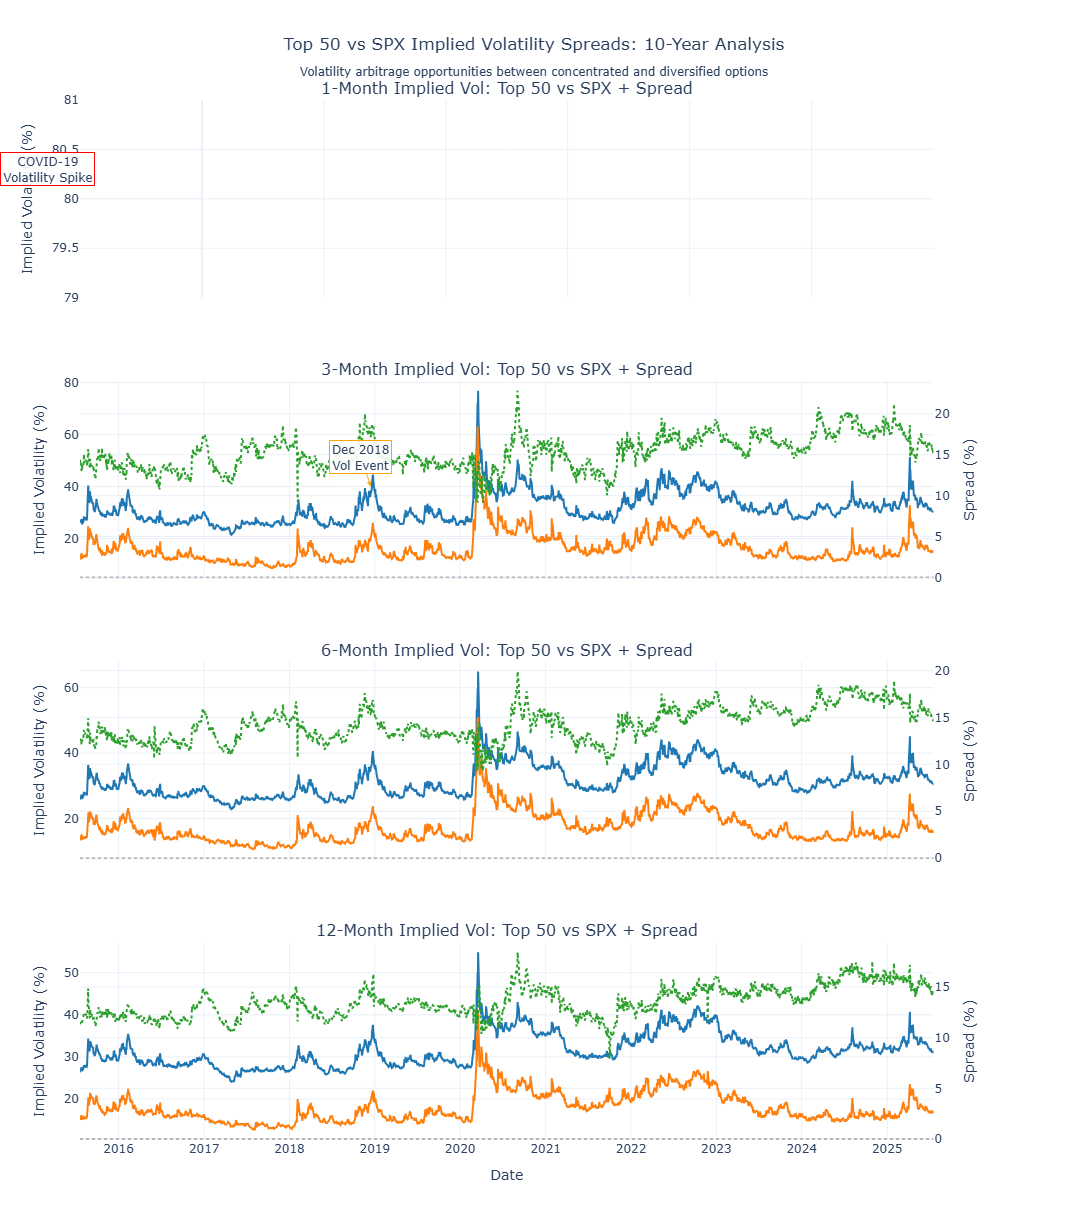

In [12]:
# Create comprehensive implied volatility spread visualization
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=[
        '1-Month Implied Vol: Top 50 vs SPX + Spread',
        '3-Month Implied Vol: Top 50 vs SPX + Spread',
        '6-Month Implied Vol: Top 50 vs SPX + Spread',
        '12-Month Implied Vol: Top 50 vs SPX + Spread'
    ],
    vertical_spacing=0.08,
    shared_xaxes=True,
    specs=[[{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": True}]]
)

# Colors
top50_color = '#1f77b4'  # Blue
spx_color = '#ff7f0e'    # Orange  
spread_color = '#2ca02c' # Green

tenor_mapping = {
    'implied_vol_1m_atm': (1, '1M'),
    'implied_vol_3m_atm': (2, '3M'),
    'implied_vol_6m_atm': (3, '6M'),
    'implied_vol_12m_atm': (4, '12M')
}

for field, (row_num, tenor_label) in tenor_mapping.items():
    top50_field = f'top50_{field}'
    spread_field = f'spread_{field}'
    
    # Check if data exists for this tenor
    if (top50_field in spread_dataset.columns and 
        field in spread_dataset.columns and 
        spread_field in spread_dataset.columns):
        
        # Filter for valid data
        valid_data = spread_dataset[[
            'date', top50_field, field, spread_field
        ]].dropna()
        
        if len(valid_data) > 0:
            # Plot Top 50 implied vol
            fig.add_trace(
                go.Scatter(
                    x=valid_data['date'],
                    y=valid_data[top50_field],
                    mode='lines',
                    name=f'Top 50 {tenor_label}',
                    line=dict(color=top50_color, width=2),
                    hovertemplate=f'<b>Top 50 {tenor_label}</b><br>Date: %{{x}}<br>Implied Vol: %{{y:.2f}}%<extra></extra>',
                    showlegend=(row_num == 1)
                ),
                row=row_num, col=1, secondary_y=False
            )
            
            # Plot SPX implied vol
            fig.add_trace(
                go.Scatter(
                    x=valid_data['date'],
                    y=valid_data[field],
                    mode='lines',
                    name=f'SPX {tenor_label}',
                    line=dict(color=spx_color, width=2),
                    hovertemplate=f'<b>SPX {tenor_label}</b><br>Date: %{{x}}<br>Implied Vol: %{{y:.2f}}%<extra></extra>',
                    showlegend=(row_num == 1)
                ),
                row=row_num, col=1, secondary_y=False
            )
            
            # Plot spread on secondary y-axis
            fig.add_trace(
                go.Scatter(
                    x=valid_data['date'],
                    y=valid_data[spread_field],
                    mode='lines',
                    name=f'Spread {tenor_label}',
                    line=dict(color=spread_color, width=2, dash='dot'),
                    hovertemplate=f'<b>Spread {tenor_label}</b><br>Date: %{{x}}<br>Top50 - SPX: %{{y:.2f}}%<extra></extra>',
                    showlegend=(row_num == 1)
                ),
                row=row_num, col=1, secondary_y=True
            )
            
            # Add zero line for spread
            fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.5, 
                         row=row_num, col=1, secondary_y=True)

# Add market event annotations
fig.add_annotation(
    x='2020-03-15', y=80,
    text="COVID-19<br>Volatility Spike",
    showarrow=True,
    arrowhead=2,
    arrowcolor="red",
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="red",
    row=1, col=1
)

fig.add_annotation(
    x='2018-12-15', y=40,
    text="Dec 2018<br>Vol Event",
    showarrow=True,
    arrowhead=2,
    arrowcolor="orange",
    bgcolor="rgba(255,255,255,0.9)",
    bordercolor="orange",
    row=2, col=1
)

# Update layout
fig.update_layout(
    title={
        'text': 'Top 50 vs SPX Implied Volatility Spreads: 10-Year Analysis<br>' +
                '<sub>Volatility arbitrage opportunities between concentrated and diversified options</sub>',
        'x': 0.5,
        'xanchor': 'center'
    },
    height=1200,
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    )
)

# Update y-axis labels
for row_num in range(1, 5):
    fig.update_yaxes(title_text="Implied Volatility (%)", row=row_num, col=1, secondary_y=False)
    fig.update_yaxes(title_text="Spread (%)", row=row_num, col=1, secondary_y=True)

fig.update_xaxes(title_text="Date", row=4, col=1)

fig.show()

#### Statistical Analysis of Implied Volatility Spreads

In [7]:
print(f"\n📊 IMPLIED VOLATILITY SPREAD STATISTICAL ANALYSIS")
print("=" * 70)

# Create comprehensive spread analysis
spread_analysis_summary = []

for field in implied_vol_fields:
    if field in spread_calculations:
        stats = spread_calculations[field]
        
        # Additional calculations
        spread_field = f'spread_{field}'
        spread_data = spread_dataset[spread_field].dropna()
        
        if len(spread_data) > 0:
            # Percentiles
            percentiles = spread_data.quantile([0.05, 0.25, 0.75, 0.95])
            
            # Extreme events
            extreme_positive = (spread_data > 5).sum()  # Spreads > 5%
            extreme_negative = (spread_data < -5).sum()  # Spreads < -5%
            
            spread_analysis_summary.append({
                'tenor': field.replace('implied_vol_', '').replace('_atm', '').upper(),
                'observations': stats['observations'],
                'mean_spread': stats['mean_spread'],
                'median_spread': stats['median_spread'],
                'std_spread': stats['std_spread'],
                'min_spread': stats['min_spread'],
                'max_spread': stats['max_spread'],
                'top50_higher_pct': stats['top50_higher_pct'],
                'p5': percentiles[0.05],
                'p25': percentiles[0.25],
                'p75': percentiles[0.75],
                'p95': percentiles[0.95],
                'extreme_positive_events': extreme_positive,
                'extreme_negative_events': extreme_negative
            })

# Display comprehensive analysis
spread_summary_df = pd.DataFrame(spread_analysis_summary)

print("COMPREHENSIVE SPREAD ANALYSIS BY TENOR:")
print("=" * 70)

for _, row in spread_summary_df.iterrows():
    tenor = row['tenor']
    print(f"\n{tenor} IMPLIED VOLATILITY SPREAD:")
    print(f"   Observations: {row['observations']:,}")
    print(f"   Mean spread: {row['mean_spread']:+.3f}%")
    print(f"   Median spread: {row['median_spread']:+.3f}%")
    print(f"   Standard deviation: {row['std_spread']:.3f}%")
    print(f"   Range: {row['min_spread']:.2f}% to {row['max_spread']:.2f}%")
    print(f"   Top 50 higher: {row['top50_higher_pct']:.1f}% of time")
    print(f"   Percentiles: P5={row['p5']:.2f}%, P25={row['p25']:.2f}%, P75={row['p75']:.2f}%, P95={row['p95']:.2f}%")
    print(f"   Extreme events: {row['extreme_positive_events']} positive (>5%), {row['extreme_negative_events']} negative (<-5%)")

# Overall insights
overall_mean_spread = spread_summary_df['mean_spread'].mean()
most_volatile_tenor = spread_summary_df.loc[spread_summary_df['std_spread'].idxmax(), 'tenor']
most_biased_tenor = spread_summary_df.loc[spread_summary_df['mean_spread'].abs().idxmax(), 'tenor']

print(f"\nOVERALL SPREAD INSIGHTS:")
print(f"   Average spread across all tenors: {overall_mean_spread:+.3f}%")
print(f"   Most volatile spread: {most_volatile_tenor}")
print(f"   Most biased spread: {most_biased_tenor}")


📊 IMPLIED VOLATILITY SPREAD STATISTICAL ANALYSIS
COMPREHENSIVE SPREAD ANALYSIS BY TENOR:

3M IMPLIED VOLATILITY SPREAD:
   Observations: 2,515
   Mean spread: +15.266%
   Median spread: +15.188%
   Standard deviation: 2.074%
   Range: 9.13% to 22.82%
   Top 50 higher: 100.0% of time
   Percentiles: P5=12.07%, P25=13.70%, P75=16.74%, P95=18.59%
   Extreme events: 2515 positive (>5%), 0 negative (<-5%)

6M IMPLIED VOLATILITY SPREAD:
   Observations: 2,515
   Mean spread: +14.281%
   Median spread: +14.187%
   Standard deviation: 1.811%
   Range: 9.27% to 19.89%
   Top 50 higher: 100.0% of time
   Percentiles: P5=11.64%, P25=12.88%, P75=15.63%, P95=17.37%
   Extreme events: 2515 positive (>5%), 0 negative (<-5%)

12M IMPLIED VOLATILITY SPREAD:
   Observations: 2,515
   Mean spread: +13.552%
   Median spread: +13.428%
   Standard deviation: 1.487%
   Range: 7.92% to 18.43%
   Top 50 higher: 100.0% of time
   Percentiles: P5=11.39%, P25=12.39%, P75=14.65%, P95=16.08%
   Extreme events: 251

#### Term Structure of Implied Volatility Spreads


📈 TERM STRUCTURE ANALYSIS OF IMPLIED VOL SPREADS


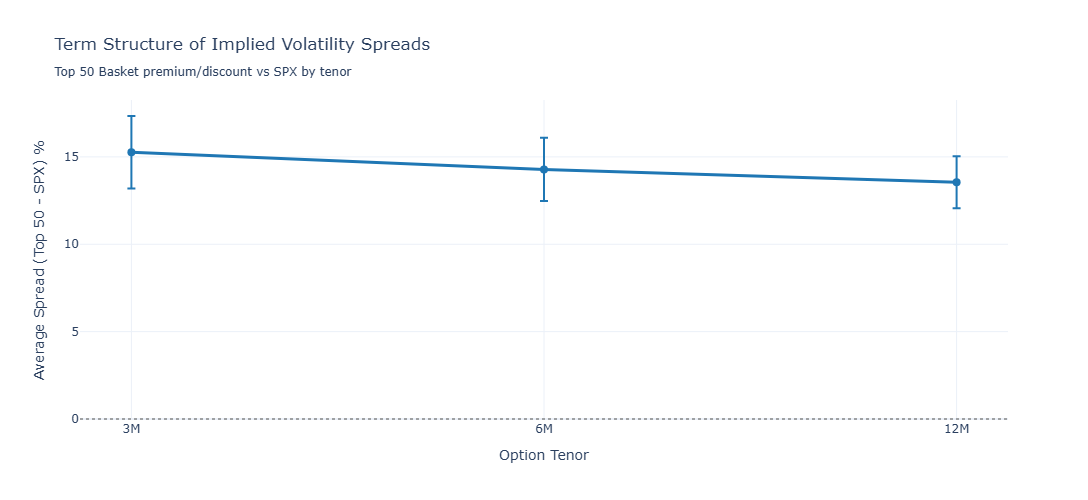

Term structure patterns:
   3M : +15.266% ± 2.074%
   6M : +14.281% ± 1.811%
   12M: +13.552% ± 1.487%

Term structure pattern: DOWNWARD SLOPING - Shorter tenors have higher Top 50 premium


In [8]:
# Analyze term structure of spreads
print(f"\n📈 TERM STRUCTURE ANALYSIS OF IMPLIED VOL SPREADS")
print("=" * 60)

# Calculate average spreads by tenor
if len(spread_summary_df) > 0:
    term_structure_data = spread_summary_df[['tenor', 'mean_spread', 'std_spread']].copy()
    term_structure_data['tenor_months'] = term_structure_data['tenor'].map({
        '1M': 1, '3M': 3, '6M': 6, '12M': 12
    })
    term_structure_data = term_structure_data.sort_values('tenor_months')
    
    # Create term structure chart
    fig = go.Figure()
    
    fig.add_trace(
        go.Scatter(
            x=term_structure_data['tenor'],
            y=term_structure_data['mean_spread'],
            mode='lines+markers',
            name='Average Spread',
            line=dict(color='#1f77b4', width=3),
            marker=dict(size=8),
            error_y=dict(
                type='data',
                array=term_structure_data['std_spread'],
                visible=True
            ),
            hovertemplate='<b>%{x}</b><br>Avg Spread: %{y:.3f}%<br>Std Dev: %{error_y.array:.3f}%<extra></extra>'
        )
    )
    
    fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.7)
    
    fig.update_layout(
        title='Term Structure of Implied Volatility Spreads<br><sub>Top 50 Basket premium/discount vs SPX by tenor</sub>',
        xaxis_title='Option Tenor',
        yaxis_title='Average Spread (Top 50 - SPX) %',
        template='plotly_white',
        height=500
    )
    
    fig.show()
    
    # Print term structure insights
    print("Term structure patterns:")
    for _, row in term_structure_data.iterrows():
        print(f"   {row['tenor']:3s}: {row['mean_spread']:+.3f}% ± {row['std_spread']:.3f}%")
    
    # Check for term structure patterns
    spreads = term_structure_data['mean_spread'].values
    if len(spreads) > 1:
        if spreads[-1] > spreads[0]:
            pattern = "UPWARD SLOPING - Longer tenors have higher Top 50 premium"
        elif spreads[-1] < spreads[0]:
            pattern = "DOWNWARD SLOPING - Shorter tenors have higher Top 50 premium"
        else:
            pattern = "FLAT - Consistent spread across tenors"
        
        print(f"\nTerm structure pattern: {pattern}")

#### Trading Strategy Implications

In [9]:
print(f"\n💰 VOLATILITY ARBITRAGE STRATEGY IMPLICATIONS")
print("=" * 70)

if len(spread_summary_df) > 0:
    # Find best arbitrage opportunities
    most_profitable_long = spread_summary_df.loc[spread_summary_df['mean_spread'].idxmin()]
    most_profitable_short = spread_summary_df.loc[spread_summary_df['mean_spread'].idxmax()]
    most_consistent = spread_summary_df.loc[spread_summary_df['std_spread'].idxmin()]
    
    print(f"SYSTEMATIC ARBITRAGE OPPORTUNITIES:")
    
    if most_profitable_short['mean_spread'] > 0.1:
        print(f"   🟢 SELL Top 50, BUY SPX ({most_profitable_short['tenor']}):")
        print(f"      Average profit: {most_profitable_short['mean_spread']:.3f}% per trade")
        print(f"      Win rate: {most_profitable_short['top50_higher_pct']:.1f}%")
        print(f"      Volatility: {most_profitable_short['std_spread']:.3f}%")
        
    if most_profitable_long['mean_spread'] < -0.1:
        print(f"   🟢 BUY Top 50, SELL SPX ({most_profitable_long['tenor']}):")
        print(f"      Average profit: {abs(most_profitable_long['mean_spread']):.3f}% per trade")
        print(f"      Win rate: {100 - most_profitable_long['top50_higher_pct']:.1f}%")
        print(f"      Volatility: {most_profitable_long['std_spread']:.3f}%")
    
    print(f"\n   🔄 MOST CONSISTENT SPREAD ({most_consistent['tenor']}):")
    print(f"      Average spread: {most_consistent['mean_spread']:+.3f}%")
    print(f"      Spread volatility: {most_consistent['std_spread']:.3f}%")
    print(f"      Sharpe-like ratio: {abs(most_consistent['mean_spread'])/most_consistent['std_spread']:.2f}")
    
    print(f"\nRISK CONSIDERATIONS:")
    max_loss_tenor = spread_summary_df.loc[spread_summary_df['min_spread'].idxmin()]
    max_gain_tenor = spread_summary_df.loc[spread_summary_df['max_spread'].idxmax()]
    
    print(f"   Maximum historical loss: {max_loss_tenor['min_spread']:.2f}% ({max_loss_tenor['tenor']})")
    print(f"   Maximum historical gain: {max_gain_tenor['max_spread']:.2f}% ({max_gain_tenor['tenor']})")
    
    # Calculate overall strategy metrics
    total_extreme_events = spread_summary_df['extreme_positive_events'].sum() + spread_summary_df['extreme_negative_events'].sum()
    total_observations = spread_summary_df['observations'].sum()
    extreme_event_pct = (total_extreme_events / total_observations) * 100
    
    print(f"   Extreme events (>5% spread): {extreme_event_pct:.2f}% of all observations")
    
    print(f"\nSTRATEGY RECOMMENDATIONS:")
    print(f"   • Focus on {most_consistent['tenor']} tenor for most reliable spreads")
    print(f"   • Monitor term structure shifts for tactical opportunities")
    print(f"   • Size positions based on spread volatility (risk parity approach)")
    print(f"   • Use correlation with market stress for dynamic hedging")

print(f"\n🎉 IMPLIED VOLATILITY SPREAD ANALYSIS COMPLETE!")
print(f"This analysis reveals:")
print(f"• Systematic pricing differences between concentrated and diversified vol")
print(f"• Quantified arbitrage opportunities across option tenors")
print(f"• Risk-adjusted returns for volatility spread strategies")
print(f"• Term structure patterns for tactical trading decisions")


💰 VOLATILITY ARBITRAGE STRATEGY IMPLICATIONS
SYSTEMATIC ARBITRAGE OPPORTUNITIES:
   🟢 SELL Top 50, BUY SPX (3M):
      Average profit: 15.266% per trade
      Win rate: 100.0%
      Volatility: 2.074%

   🔄 MOST CONSISTENT SPREAD (12M):
      Average spread: +13.552%
      Spread volatility: 1.487%
      Sharpe-like ratio: 9.12

RISK CONSIDERATIONS:
   Maximum historical loss: 7.92% (12M)
   Maximum historical gain: 22.82% (3M)
   Extreme events (>5% spread): 100.00% of all observations

STRATEGY RECOMMENDATIONS:
   • Focus on 12M tenor for most reliable spreads
   • Monitor term structure shifts for tactical opportunities
   • Size positions based on spread volatility (risk parity approach)
   • Use correlation with market stress for dynamic hedging

🎉 IMPLIED VOLATILITY SPREAD ANALYSIS COMPLETE!
This analysis reveals:
• Systematic pricing differences between concentrated and diversified vol
• Quantified arbitrage opportunities across option tenors
• Risk-adjusted returns for volatil